# Imports

In [33]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.approximation import steiner_tree

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# Create graph

In [34]:
edges           = pd.read_csv('../data/edges_191120.csv')
nodes           = pd.read_csv('../data/nodes_191120.csv', index_col=0)
ingr2cat        = pd.read_csv('../data/dict_ingr2cate.csv')
all_categories = set(ingr2cat['category'].values)

embeddings_dict = pickle.load(open('../data/FlavorGraph_Node_Embedding.pickle', 'rb'))

id_to_name = dict(zip(nodes.index, nodes['name']))

ingredients_idx = nodes[nodes['node_type']=='ingredient'].index.tolist()
nodes           = nodes.loc[ingredients_idx]#.reset_index(drop=True)
embeddings_dict = {k: embeddings_dict[k] for k in map(str, ingredients_idx)}

In [35]:
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['id_1'], row['id_2'], weight=row['score'], type=row['edge_type'])
for node_id, row in nodes.iterrows():
    G.add_node(node_id, name=row['name'], node_type=row['node_type'], is_hub=row['is_hub'])

In [36]:
# remove nodes from graph that are not ingredients
to_remove = [n for n in G.nodes if n not in nodes.index]
G.remove_nodes_from(to_remove)

# remove nodes that are not hubs
# to_remove = [n for n, attr in G.nodes(data=True) if attr['is_hub'] != 'hub']
# G.remove_nodes_from(to_remove)

In [37]:
# Remove NaN edges
to_remove = [(u, v) for u, v, attr in G.edges(data=True) if pd.isna(attr['weight'])]
G.remove_edges_from(to_remove)

# Remove isolated nodes (nodes with degree 0)
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
print(f"Removed {len(isolated)} isolated nodes")

Removed 0 isolated nodes


# Get ID from NAME

In [38]:
subset = nodes[nodes['name'].str.contains('cauliflower', case=False, na=False)]
subset = subset[subset['is_hub'] == 'hub']
subset

,name,id,node_type,is_hub
node_id,,,,
1027,cauliflower,NaN,ingredient,hub


In [39]:
terminals = [4635, 6441, 1027]
food_names = [id_to_name[t] for t in terminals]
food_names

['pasta', 'tomato', 'cauliflower']

# Embedding methods

In [40]:
food_embeddings = np.array([embeddings_dict[str(t)] for t in terminals])
combi_embedding = np.mean(food_embeddings, axis=0)

In [41]:
# compute cosine similarity between combined embedding and all ingredient embeddings
all_embeddings = np.array([embeddings_dict[str(n)] for n in G.nodes()])
similarities = cosine_similarity([combi_embedding], all_embeddings).flatten()

# get top N most similar ingredients (not in terminals)
N = 10
similarity_series = pd.Series(similarities, index=G.nodes())
similarity_series = similarity_series.drop(index=terminals)
top_n = similarity_series.nlargest(N)
top_n_ingredients = [(idx, id_to_name[idx], score) for idx, score in top_n.items()]
top_n_ingredients

[(4797, 'pickled_onion', 0.684895396232605),
 (6500, 'tuna_in_brine', 0.6660234928131104),
 (6690, 'vegan_burger', 0.6168347001075745),
 (2532, 'fresh_mozzarella_ball', 0.6159921288490295),
 (1666, 'cranberry_bean', 0.6124050617218018),
 (66, 'ahi', 0.6122167110443115),
 (3790, 'light_balsamic_vinaigrette_salad_dressing', 0.608479380607605),
 (7023, 'wishbone_italian_dressing', 0.6034201383590698),
 (4569, 'oven_roasted_turkey_breast', 0.6028760075569153),
 (3580, 'kingfish', 0.6018878221511841)]

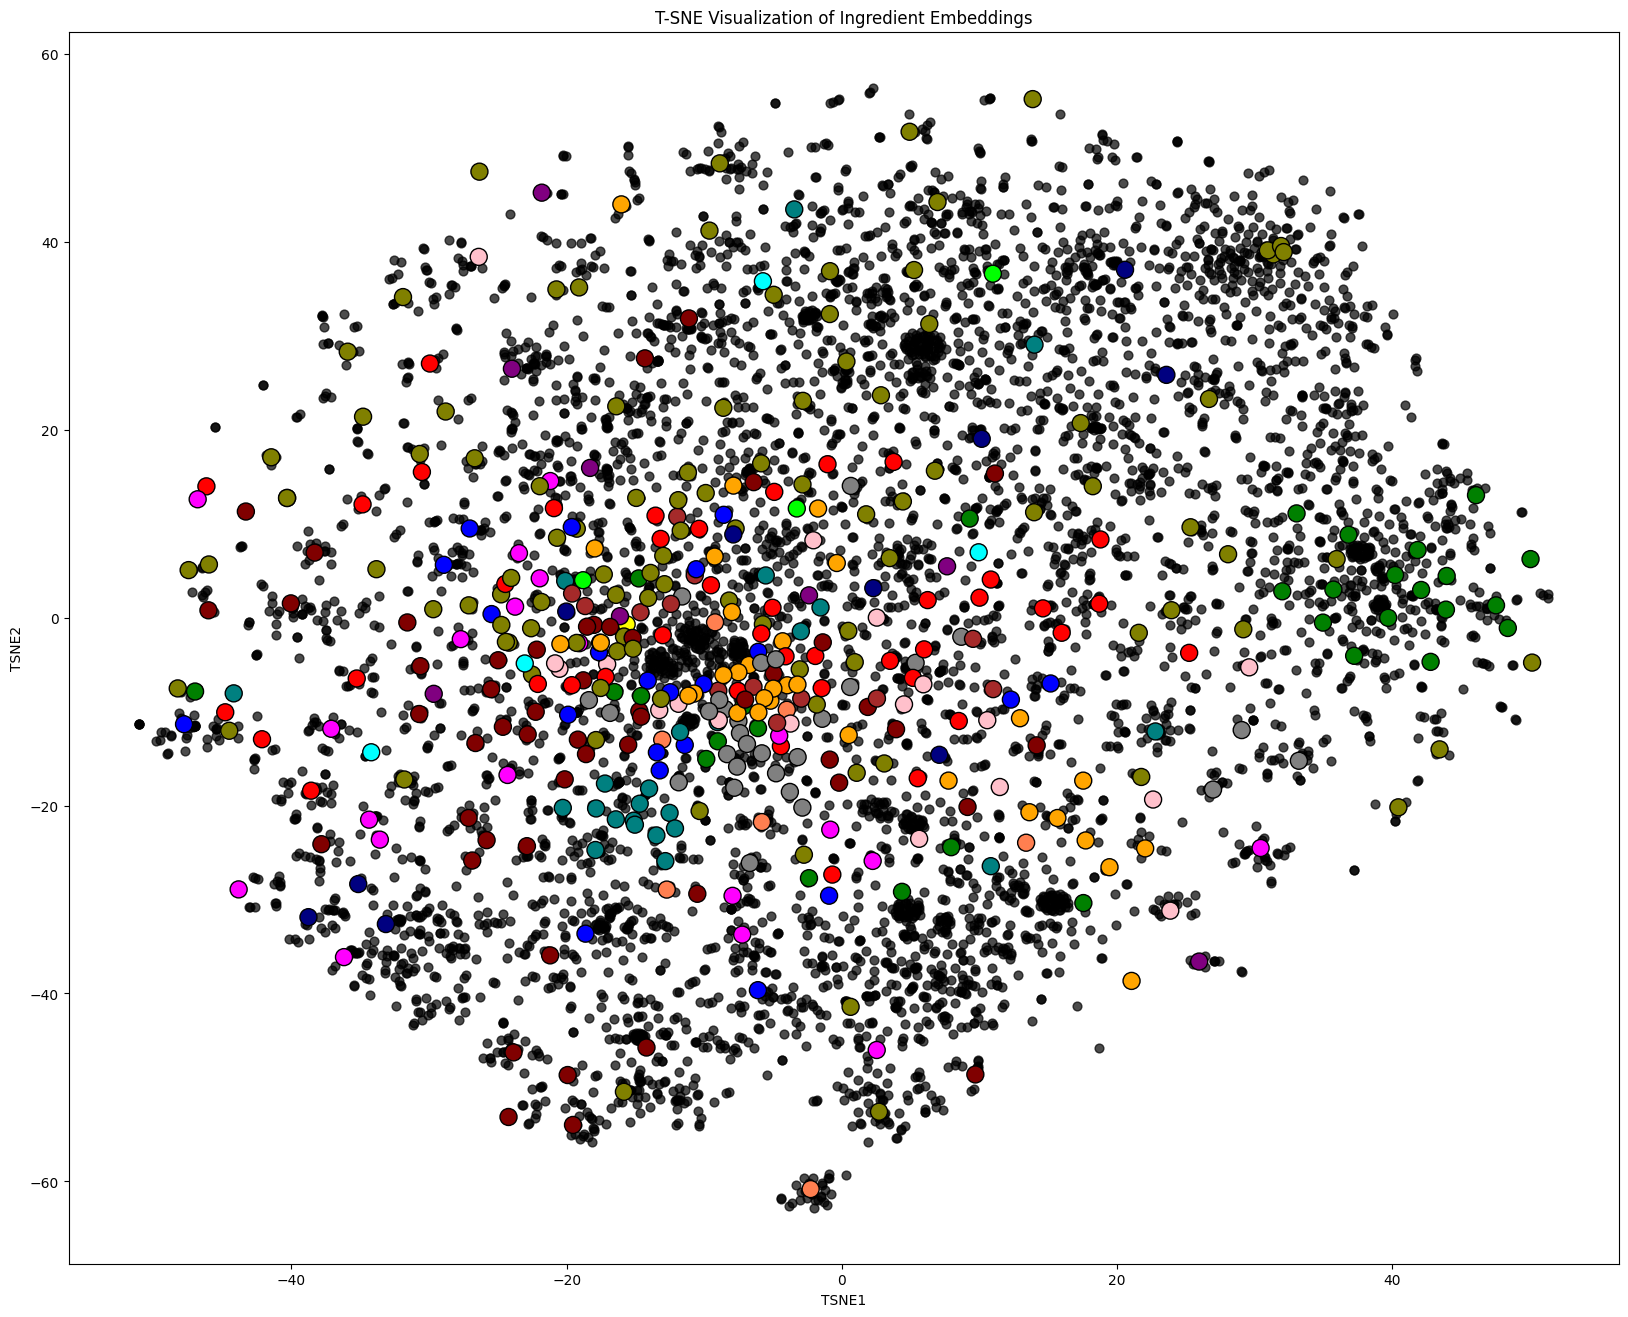

In [63]:
# Apply T-SNE to visualize all embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100, random_state=42)
# all_embeddings_nohub = np.array([embeddings_dict[str(n)] for n in G.nodes()])
all_embeddings_2d = tsne.fit_transform(all_embeddings)
embedding_df = pd.DataFrame(all_embeddings_2d, index=G.nodes(), columns=['TSNE1', 'TSNE2'])
# remove non hub nodes
# embedding_df = embedding_df.loc[nodes[nodes['is_hub']=='hub'].index]

# define point categories from ingr2cat
ingr2cat_dict = dict(zip(ingr2cat['ingredient'], ingr2cat['category']))
embedding_df['category'] = embedding_df.index.map(lambda x: ingr2cat_dict.get(id_to_name[x], np.nan))
cat_colors = {
    'Cereal/Crop/Bean': 'red',
    'Sauce/Powder/Dressing': 'blue',
    'Dairy': 'green',
    'Seafood': 'orange',
    'Essential Oil/Fat': 'purple',
    'Dish/End Product': 'brown',
    'Meat/Animal Product': 'pink',
    'Bakery/Dessert/Snack': 'gray',
    'Plant/Vegetable': 'olive',
    'Flower': 'cyan',
    'Nut/Seed': 'magenta',
    'ETC': 'yellow',
    'Beverage Alcoholic': 'teal',
    'Spice': 'navy',
    'Fruit': 'maroon',
    'Fungus': 'lime',
    'Beverage': 'coral'
}  
embedding_df['color'] = embedding_df['category'].map(cat_colors).fillna('black')

plt.figure(figsize=(20, 16))

is_hub = nodes.loc[embedding_df.index, 'is_hub']
hub_embeddings   = embedding_df[is_hub == 'hub']
nohub_embeddings = embedding_df[is_hub != 'hub']
plt.scatter(nohub_embeddings['TSNE1'], nohub_embeddings['TSNE2'], color='k', alpha=0.7, s=40)
plt.scatter(hub_embeddings['TSNE1'], hub_embeddings['TSNE2'], c=hub_embeddings['color'], edgecolor='k', s=150)


plt.title('T-SNE Visualization of Ingredient Embeddings')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()


# Graph algorithms

### Shortest path between 2 nodes

In [43]:
# find shortest path between two ingredients
def find_shortest_path(ingr_id_1, ingr_id_2):
    try:
        path = nx.shortest_path(G, source=ingr_id_1, target=ingr_id_2, weight='weight', method='dijkstra')
        return path
    except nx.NetworkXNoPath:
        return None
    
ingr_id_1 = terminals[0]  
ingr_id_2 = terminals[1]
print(f"Finding shortest path between {id_to_name[ingr_id_1].upper()} and {id_to_name[ingr_id_2].upper()}:")
path = find_shortest_path(ingr_id_1, ingr_id_2)
if path:
    path_names = [id_to_name[node_id] for node_id in path]
    print(" -> ".join(path_names))
else:
    print(f"No path found between {id_to_name[ingr_id_1]} and {id_to_name[ingr_id_2]}")

Finding shortest path between PASTA and TOMATO:
pasta -> sun_dried_tomato_pesto -> garlic -> canned_chicken -> lemon_juice -> nonfat_cottage_cheese -> tomato


### Smallest subgraph with K specific nodes

In [44]:
# Steiner Tree Problem: find smallest subgraph that includes K nodes
steiner_subgraph = steiner_tree(G, terminals, weight='weight')
print("Steiner Tree Nodes:")
for node_id in steiner_subgraph.nodes:
    print(f"{node_id}: {id_to_name[node_id]}")


Steiner Tree Nodes:
4419: nonfat_cottage_cheese
1027: cauliflower
903: canned_chicken
5608: salt
2793: garlic
6218: sun_dried_tomato_pesto
6441: tomato
5038: poultry
5371: reduced_fat_margarine
5622: salt_water
4635: pasta
2396: flour
3743: lemon_juice


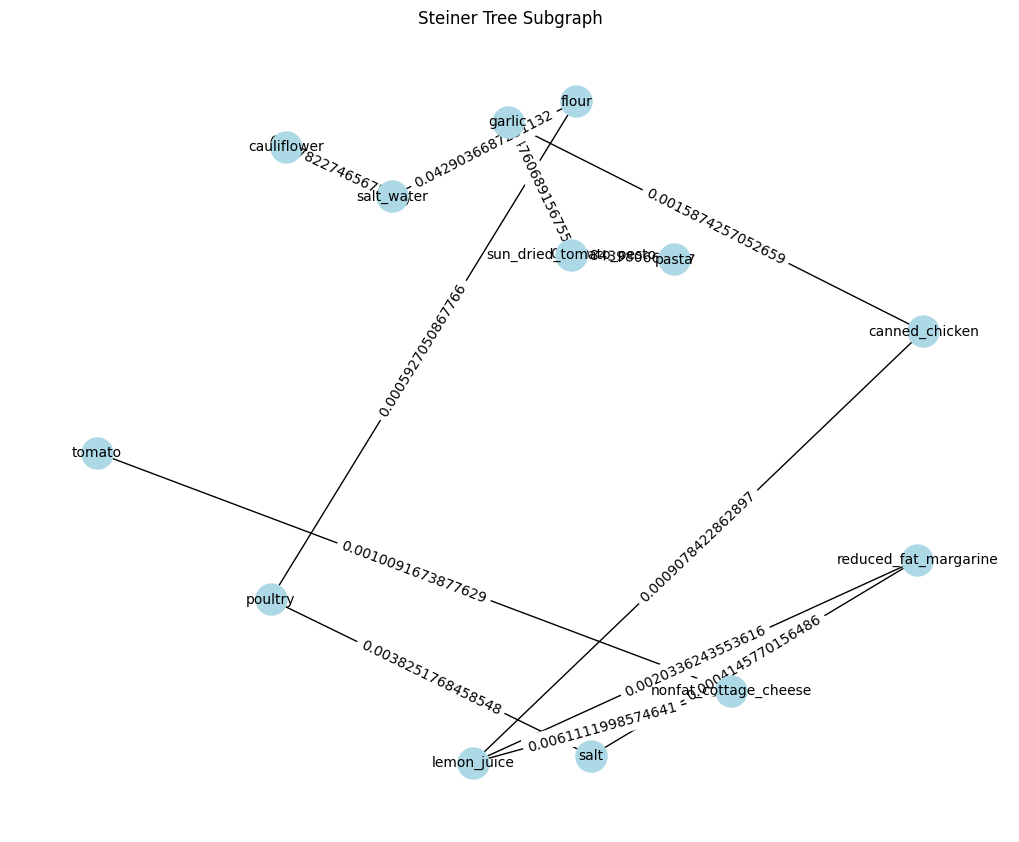

In [45]:

# Visualize the Steiner Tree
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(steiner_subgraph)
nx.draw(steiner_subgraph, pos, with_labels=True, labels={n: id_to_name[n] for n in steiner_subgraph.nodes}, node_size=500, node_color='lightblue', font_size=10)
edge_labels = nx.get_edge_attributes(steiner_subgraph, 'weight')
nx.draw_networkx_edge_labels(steiner_subgraph, pos, edge_labels=edge_labels)
plt.title("Steiner Tree Subgraph")
plt.show()

In [46]:
def connecting_backbone(G, terminals):
    """Find minimal subgraph connecting all terminals, preferring shared nodes"""
    
    # Find ALL shortest paths between terminal pairs
    all_shortest_paths = {}
    for i, t1 in enumerate(terminals):
        for t2 in terminals[i+1:]:
            # Get all shortest paths
            paths = list(nx.all_shortest_paths(G, t1, t2))
            all_shortest_paths[(t1, t2)] = paths
    
    # Score each path by how many times its intermediate nodes appear in other paths
    def score_path(path, all_paths):
        intermediates = set(path[1:-1])
        score = 0
        for other_paths in all_paths.values():
            for other_path in other_paths:
                other_intermediates = set(other_path[1:-1])
                score += len(intermediates & other_intermediates)
        return score
    
    # Choose best path for each terminal pair
    best_paths = {}
    for (t1, t2), paths in all_shortest_paths.items():
        best_path = max(paths, key=lambda p: score_path(p, all_shortest_paths))
        best_paths[(t1, t2)] = best_path
    
    # Build MST using these paths
    terminal_graph = nx.Graph()
    for (t1, t2), path in best_paths.items():
        terminal_graph.add_edge(t1, t2, weight=len(path) - 1, path=path)
    
    mst = nx.minimum_spanning_tree(terminal_graph)
    
    # Collect edges from MST paths
    edges = set()
    for t1, t2, data in mst.edges(data=True):
        path = data['path']
        for j in range(len(path) - 1):
            edges.add((path[j], path[j+1]))
    
    nodes = set(node for edge in edges for node in edge)
    return G.subgraph(nodes).copy()

result = connecting_backbone(G, terminals)

In [47]:
# show adjacency matrix
adj_matrix = nx.adjacency_matrix(result).todense()
adj_df = pd.DataFrame(adj_matrix, index=[id_to_name[n] for n in result.nodes], columns=[id_to_name[n] for n in result.nodes])

mat = (adj_df>0).astype(int)
mat

,cauliflower,tomato,stock_cube,capsicum,pasta
cauliflower,0,0,0,1,0
tomato,0,0,1,1,0
stock_cube,0,1,0,0,1
capsicum,1,1,0,0,0
pasta,0,0,1,0,0


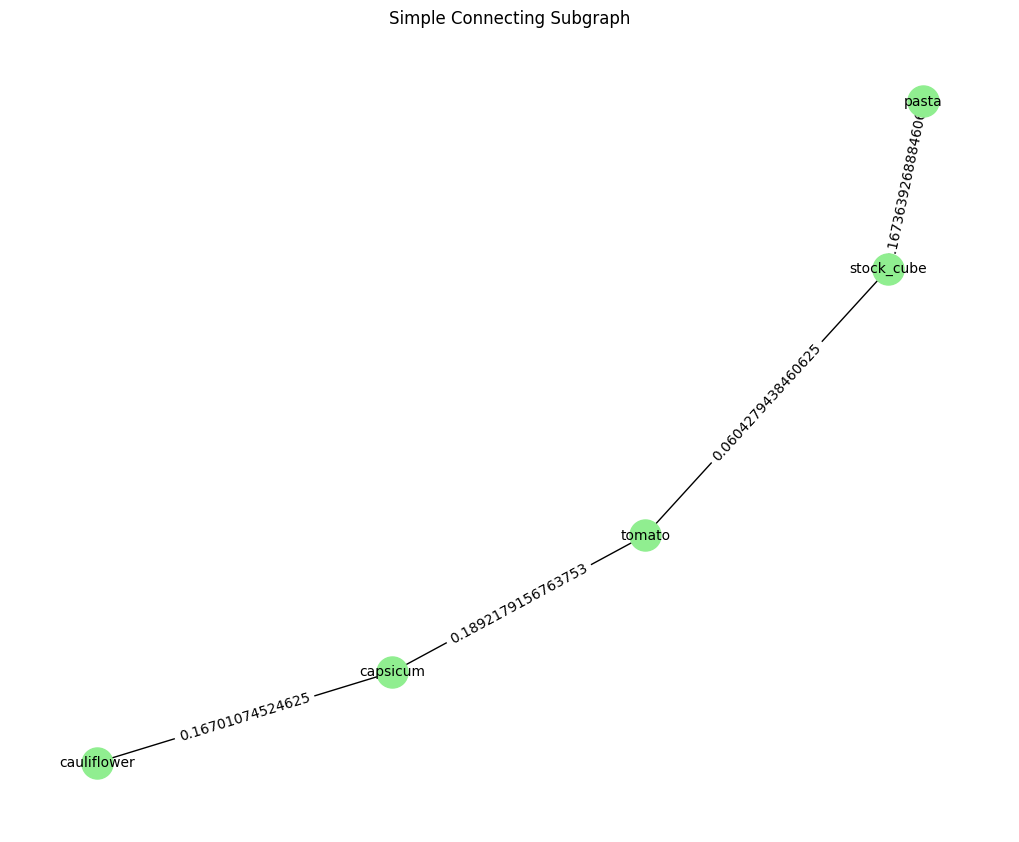

In [48]:
# visualize the resulting subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(result)
nx.draw(result, pos, with_labels=True, labels={n: id_to_name[n] for n in result.nodes}, node_size=500, node_color='lightgreen', font_size=10)
edge_labels = nx.get_edge_attributes(result, 'weight')
nx.draw_networkx_edge_labels(result, pos, edge_labels=edge_labels)
plt.title("Simple Connecting Subgraph")
plt.show()